In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam import DirectLiNGAM
from sklearn.preprocessing import StandardScaler, MinMaxScaler

np.set_printoptions(precision=3, suppress=True)
np.random.seed(100)

X = pd.read_csv('/teamspace/studios/this_studio/dataset/low_scrap.csv')
#deselect the clast column 
#X = X.drop(columns=['Faulty'])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
dfX = pd.DataFrame(X_scaled, columns=X.columns)
dfX


,Station1_mp_0,Station1_mp_1,Station1_mp_2,Station1_mp_3,Station1_mp_4,Station1_mp_5,Station2_mp_6,Station2_mp_7,Station2_mp_8,Station2_mp_9,...,Station5_mp_88,Station5_mp_89,Station5_mp_90,Station5_mp_91,Station5_mp_92,Station5_mp_93,Station5_mp_94,Station5_mp_95,Station5_mp_96,Station5_mp_97
0,0.358164,0.555556,0.333333,0.576643,0.555556,0.25,0.535899,0.883405,0.593638,0.628770,...,0.410249,0.778599,0.535427,0.265618,0.546479,0.412162,0.107879,0.586235,0.218750,0.770765
1,0.769085,0.333333,0.333333,0.547709,0.777778,0.50,0.647349,0.924414,0.627154,0.660695,...,0.251333,0.811809,0.535427,0.580603,0.504225,0.574325,0.124848,0.434932,0.119572,0.724253
2,0.335473,0.666667,0.666667,0.372585,0.444444,0.50,0.712342,0.459829,0.649498,0.663534,...,0.257916,0.579336,0.224273,0.885539,0.515493,0.540540,0.093333,0.083233,0.196710,0.594684
3,0.405855,0.444444,0.666667,0.549280,0.777778,0.50,0.518122,0.728286,0.481348,0.495743,...,0.418149,0.867160,0.393093,0.550896,0.619718,0.527026,0.077576,0.382873,0.206165,0.777409
4,0.617633,0.444444,0.333333,0.468090,0.333333,0.50,0.698958,0.299288,0.535694,0.546116,...,0.388332,0.833950,0.523102,0.488423,0.552114,0.128378,0.092121,0.477782,0.106325,0.747509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.591702,0.222222,0.333333,0.529339,0.555556,1.00,0.536700,0.295125,0.412233,0.474814,...,0.572035,0.745387,0.422050,0.829183,0.290141,0.168919,0.876364,0.215506,0.224590,0.372093
2496,0.238279,0.444444,0.333333,0.498527,0.333333,0.50,0.662789,0.520888,0.758379,0.769777,...,0.436957,0.859780,0.594572,0.502839,0.529577,0.364865,0.107879,0.513509,0.430201,0.750831
2497,0.295491,0.333333,0.666667,0.734777,0.222222,0.25,0.703710,0.592439,0.606325,0.639057,...,0.152415,0.830258,0.376461,0.671909,0.721127,0.324325,0.049697,0.347217,0.342505,0.853821
2498,0.508141,0.333333,0.333333,0.716265,0.333333,0.50,0.338562,0.507380,0.579247,0.608194,...,0.511363,0.826568,0.566230,0.296636,0.529577,0.614865,0.141818,0.640032,0.242345,0.644519


In [2]:
def prior_knowledge_matrix(columns):
    """
    prior knowledge matrix for LiNGAM where:
    0: no directed path possible (temporal constraint violation)
    1: directed path 
    -1: no prior knowledge (we'll allow the algorithm to determine)
    """
    n_features = len(columns)
    prior_knowledge = np.full((n_features, n_features), -1)
    
    # get station number 
    def get_station_number(col_name):
        return int(col_name.split('_')[0].replace('Station', ''))
    
    # get measurement point number
    def get_mp_number(col_name):
        return int(col_name.split('_')[2])
    
    for i in range(n_features):
        for j in range(n_features):
            station_i = get_station_number(columns[i])
            station_j = get_station_number(columns[j])
            
            # constraint
            if station_i > station_j:
                prior_knowledge[i, j] = 0
            
            # should we allow internal dependencies? 
            # if station_i == station_j:
            #     prior_knowledge[i, j] = -1  # Let LiNGAM determine
    
    # No self loop allowed
    np.fill_diagonal(prior_knowledge, 0)
    
    return prior_knowledge


# Create the prior knowledge matrix
prior_knowledge = prior_knowledge_matrix(dfX.columns)


#with priors
model = DirectLiNGAM(prior_knowledge=prior_knowledge.T)

In [3]:
prior_knowledge.T

array([[ 0, -1, -1, ...,  0,  0,  0],
       [-1,  0, -1, ...,  0,  0,  0],
       [-1, -1,  0, ...,  0,  0,  0],
       ...,
       [-1, -1, -1, ...,  0, -1, -1],
       [-1, -1, -1, ..., -1,  0, -1],
       [-1, -1, -1, ..., -1, -1,  0]])

In [4]:
checker = pd.DataFrame(prior_knowledge.T, columns=X.columns, index=X.columns)
checker

,Station1_mp_0,Station1_mp_1,Station1_mp_2,Station1_mp_3,Station1_mp_4,Station1_mp_5,Station2_mp_6,Station2_mp_7,Station2_mp_8,Station2_mp_9,...,Station5_mp_88,Station5_mp_89,Station5_mp_90,Station5_mp_91,Station5_mp_92,Station5_mp_93,Station5_mp_94,Station5_mp_95,Station5_mp_96,Station5_mp_97
Station1_mp_0,0,-1,-1,-1,-1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Station1_mp_1,-1,0,-1,-1,-1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Station1_mp_2,-1,-1,0,-1,-1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Station1_mp_3,-1,-1,-1,0,-1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Station1_mp_4,-1,-1,-1,-1,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Station5_mp_93,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,0,-1,-1,-1,-1
Station5_mp_94,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,0,-1,-1,-1
Station5_mp_95,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,0,-1,-1
Station5_mp_96,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,0,-1


In [5]:
#checker["Station4_mp_70"]["Station5_mp_95"] #Station5_mp_95
#BEFORE CHANGE

In [6]:
model.fit(dfX)

In [7]:
make_dot(model.adjacency_matrix_, labels=list(dfX.columns)).render('relaxed_constrained_graph_LOW', format='pdf')


'relaxed_constrained_graph_LOW.pdf'

* i should add an analysis for the target variable: biggest effects on the target variable Station5_mp_85
* check p values


In [ ]:
#check p values
model.get_error_independence_p_values(X)

In [8]:
#store the adj matrix for later used as a dataframe
adj_matrix = pd.DataFrame(model.adjacency_matrix_, columns=X.columns, index=X.columns)
adj_matrix.to_csv('adj_matrix_jb_LOW.csv')

In [53]:
adj_matrix["Station2_mp_28"]["Station5_mp_85"]  #Station2_mp_28 # Station5_mp_85

0.162946152959047

# subgraph

In [9]:
#unscale the adj matrix data
adj_matrix = model.adjacency_matrix_
adj_matrix = scaler.inverse_transform(adj_matrix)
adj_matrixdf = pd.DataFrame(adj_matrix, columns=X.columns, index=X.columns)
adj_matrixdf

,Station1_mp_0,Station1_mp_1,Station1_mp_2,Station1_mp_3,Station1_mp_4,Station1_mp_5,Station2_mp_6,Station2_mp_7,Station2_mp_8,Station2_mp_9,...,Station5_mp_88,Station5_mp_89,Station5_mp_90,Station5_mp_91,Station5_mp_92,Station5_mp_93,Station5_mp_94,Station5_mp_95,Station5_mp_96,Station5_mp_97
Station1_mp_0,0.000098,4.000000,1.000000,0.000125,10.0,2.000000,32028.938392,0.003555,49700.92,31831.66,...,3.830272e+06,0.004488,10604.790000,5191.198000,0.004932,339.0301,0.000426,3983.037666,3.806183e+06,0.004416
Station1_mp_1,0.000086,4.000000,1.593627,0.000125,10.0,2.000000,32028.938392,0.003555,49700.92,31831.66,...,3.830272e+06,0.004488,10604.790000,5191.198000,0.004932,339.0301,0.000426,3983.037666,3.806183e+06,0.004416
Station1_mp_2,0.000098,4.000000,1.000000,0.000125,10.0,2.000000,32028.938392,0.003555,49700.92,31831.66,...,3.830272e+06,0.004488,10604.790000,5191.198000,0.004932,339.0301,0.000426,3983.037666,3.806183e+06,0.004416
Station1_mp_3,0.000098,4.000000,1.000000,0.000125,10.0,2.271206,32028.938392,0.003555,49700.92,31831.66,...,3.830272e+06,0.004488,10604.790000,5191.198000,0.004932,339.0301,0.000426,3983.037666,3.806183e+06,0.004416
Station1_mp_4,0.000098,5.443593,1.000000,0.000134,10.0,3.026892,32028.938392,0.003555,49700.92,31831.66,...,3.830272e+06,0.004488,10604.790000,5191.198000,0.004932,339.0301,0.000426,3983.037666,3.806183e+06,0.004416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Station5_mp_93,0.000098,4.000000,1.000000,0.000125,10.0,2.000000,32028.938392,0.003555,49700.92,31831.66,...,3.830272e+06,0.004488,10604.790000,5191.198000,0.004932,339.0301,0.000426,3983.037666,3.806183e+06,0.004416
Station5_mp_94,0.000098,4.000000,1.000000,0.000125,10.0,2.000000,32028.938392,0.003555,49700.92,31831.66,...,3.830272e+06,0.004488,10604.790000,5191.198000,0.004932,339.0301,0.000426,3983.037666,3.806183e+06,0.004416
Station5_mp_95,0.000098,4.000000,1.000000,0.000125,10.0,2.000000,32028.938392,0.003555,49700.92,31831.66,...,3.830272e+06,0.004488,10956.141015,4320.731538,0.004932,339.0301,0.000426,3983.037666,3.806183e+06,0.004416
Station5_mp_96,0.000098,4.000000,1.000000,0.000125,10.0,2.000000,32028.938392,0.003555,49700.92,31831.66,...,3.830272e+06,0.004488,10604.790000,5191.198000,0.004932,339.0301,0.000426,3983.037666,3.806183e+06,0.004416


In [23]:
def backtrack_to_target(adjacency_matrix, columns, target_col='Station5_mp_85'):
    """
    Efficiently find all nodes with paths leading to the target node in a directed graph using backtracking.
    """
    # Convert columns to a list if it's an Index
    columns = list(columns)
    target_idx = columns.index(target_col)
    
    # Initialize the directed graph and set for nodes to backtrack
    G = nx.DiGraph()
    nodes_to_visit = [target_idx]
    visited_nodes = set()

    # Backtrack from target node through incoming edges
    while nodes_to_visit:
        current = nodes_to_visit.pop()
        if current not in visited_nodes:
            visited_nodes.add(current)
            for i, has_edge in enumerate(adjacency_matrix[:, current]):
                if has_edge != 0:  # Edge exists from i to current
                    G.add_edge(i, current, weight=has_edge)
                    nodes_to_visit.append(i)

    # Add node labels
    nx.set_node_attributes(G, {i: columns[i] for i in G.nodes()}, 'label')

    return G

# Example usage
subgraph = backtrack_to_target(model.adjacency_matrix_.T, dfX.columns)
subgraph

In [29]:
target_idx = list(dfX.columns).index("Station5_mp_85")
target_idx

85

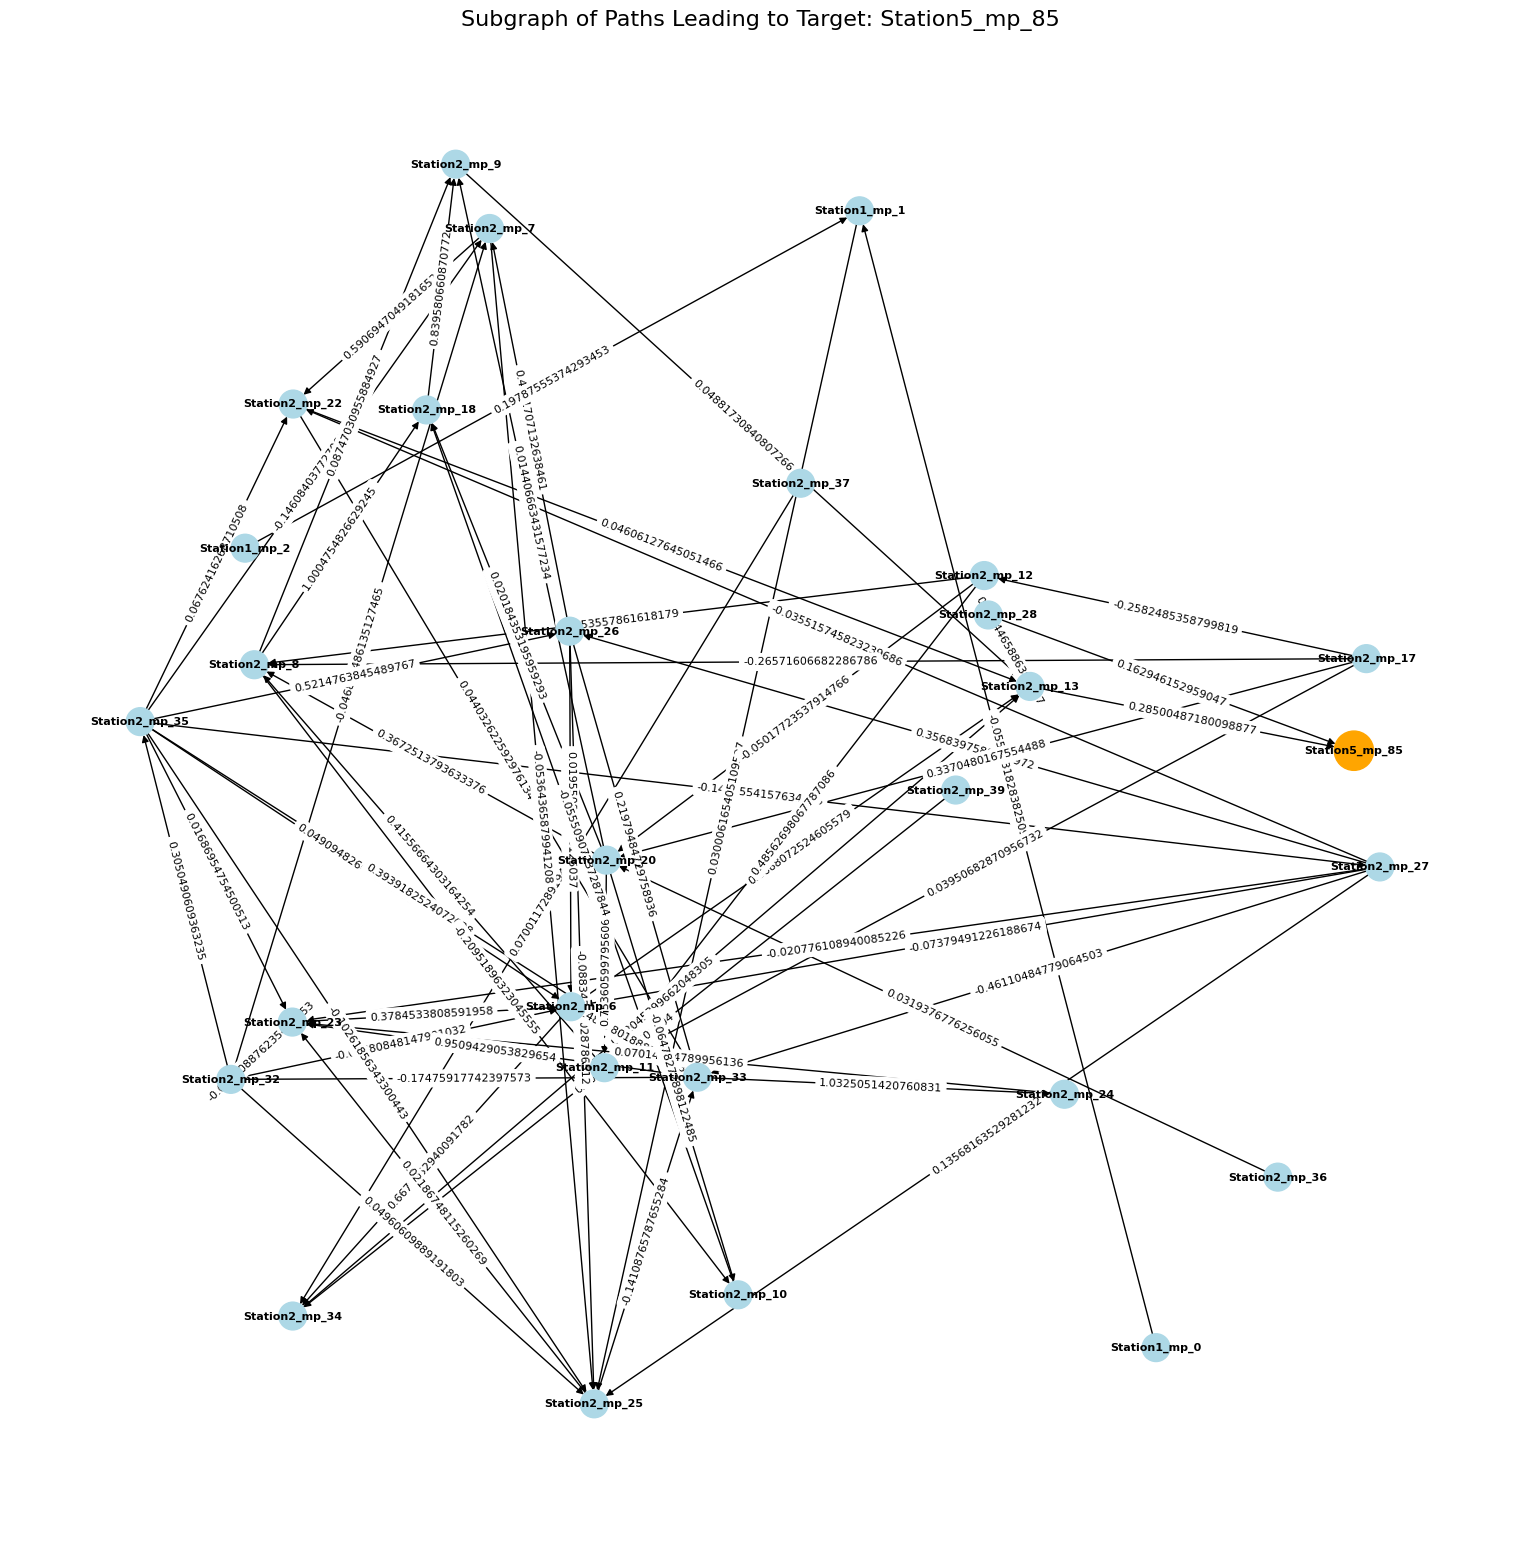

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_enhanced_subgraph(subgraph, columns, target_col='Station5_mp_85'):
    """
    Plot a visually enhanced subgraph centered on the target node, using indices instead of labels.
    """
    # Convert columns to list if it's an Index and find the target index
    columns = list(columns)
    target_idx = columns.index(target_col)
    
    # Define a tree-like layout without specifying center
    pos = nx.spring_layout(subgraph, k=0.5)

    # Set figure size for larger networks
    plt.figure(figsize=(15, 15))
    
    # Draw nodes with different colors for target and non-target nodes
    node_colors = ['lightblue' if node != target_idx else 'orange' for node in subgraph.nodes()]
    node_sizes = [800 if node == target_idx else 400 for node in subgraph.nodes()]

    # Draw the graph with labels mapped to column names
    labels = {node: columns[node] for node in subgraph.nodes()}
    nx.draw(subgraph, pos, with_labels=True, labels=labels,
            node_color=node_colors, node_size=node_sizes, font_size=8, font_weight="bold", arrows=True)

    # Draw edge weights for better visibility
    edge_labels = nx.get_edge_attributes(subgraph, 'weight')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Subgraph of Paths Leading to Target: {target_col}", fontsize=16)
    plt.show()

# Plot the enhanced subgraph with target label
plot_enhanced_subgraph(subgraph, dfX.columns, target_col='Station5_mp_85')

In [18]:
subgraph

In [30]:
target_idx = list(dfX.columns).index("Station5_mp_85")
paths_to_target = []
for node in subgraph.nodes:
    if node != target_idx and nx.has_path(subgraph, node, target_idx):
        paths_to_target.extend(nx.all_simple_paths(subgraph, source=node, target=target_idx))

In [31]:
paths_to_target

[[13, 85],
 [13, 28, 85],
 [28, 85],
 [6, 13, 85],
 [6, 13, 28, 85],
 [6, 34, 13, 85],
 [6, 34, 13, 28, 85],
 [9, 13, 85],
 [9, 13, 28, 85],
 [22, 13, 85],
 [22, 13, 28, 85],
 [22, 33, 6, 13, 85],
 [22, 33, 6, 13, 28, 85],
 [22, 33, 6, 34, 13, 85],
 [22, 33, 6, 34, 13, 28, 85],
 [22, 33, 23, 6, 13, 85],
 [22, 33, 23, 6, 13, 28, 85],
 [22, 33, 23, 6, 34, 13, 85],
 [22, 33, 23, 6, 34, 13, 28, 85],
 [22, 33, 24, 23, 6, 13, 85],
 [22, 33, 24, 23, 6, 13, 28, 85],
 [22, 33, 24, 23, 6, 34, 13, 85],
 [22, 33, 24, 23, 6, 34, 13, 28, 85],
 [34, 13, 85],
 [34, 13, 28, 85],
 [37, 34, 13, 85],
 [37, 34, 13, 28, 85],
 [39, 34, 13, 85],
 [39, 34, 13, 28, 85],
 [23, 6, 13, 85],
 [23, 6, 13, 28, 85],
 [23, 6, 34, 13, 85],
 [23, 6, 34, 13, 28, 85],
 [26, 6, 13, 85],
 [26, 6, 13, 28, 85],
 [26, 6, 34, 13, 85],
 [26, 6, 34, 13, 28, 85],
 [26, 33, 6, 13, 85],
 [26, 33, 6, 13, 28, 85],
 [26, 33, 6, 34, 13, 85],
 [26, 33, 6, 34, 13, 28, 85],
 [26, 33, 23, 6, 13, 85],
 [26, 33, 23, 6, 13, 28, 85],
 [26, 33, 2

In [34]:
# Calculate total effects for each path
path_effects = {}
for path in paths_to_target:
    total_effect = 0
    for i in range(len(path) - 1):
        effect = model.estimate_total_effect(dfX, path[i], path[-1])
        total_effect += effect
    path_effects[tuple(path)] = total_effect

In [36]:
# Identify path with the maximum total effect
most_influential_path = max(path_effects, key=path_effects.get)
max_effect = path_effects[most_influential_path]
target_idx = dfX.columns.get_loc('Station5_mp_85')
print("Most Influential Path:", most_influential_path)
print("Maximum Total Effect:", max_effect)

Most Influential Path: (35, 27, 26, 7, 22, 13, 28, 85)
Maximum Total Effect: 0.5919081031321047


In [39]:
#sort path effects:
sorted_path_effects = sorted(path_effects.items(), key=lambda x: x[1], reverse=True)
sorted_path_effects

[((35, 27, 26, 7, 22, 13, 28, 85), 0.5919081031321047),
 ((27, 26, 7, 22, 13, 28, 85), 0.59124223802648),
 ((35, 27, 22, 13, 28, 85), 0.5894684583782237),
 ((27, 22, 13, 28, 85), 0.588802593272599),
 ((32, 35, 27, 26, 7, 22, 13, 28, 85), 0.574118196834638),
 ((32, 35, 27, 22, 13, 28, 85), 0.571678552080757),
 ((35, 26, 7, 22, 13, 28, 85), 0.5568866213374637),
 ((26, 7, 22, 13, 28, 85), 0.556220756231839),
 ((35, 22, 13, 28, 85), 0.5544469765835827),
 ((22, 13, 28, 85), 0.5537811114779579),
 ((35, 7, 22, 13, 28, 85), 0.5414216032352384),
 ((7, 22, 13, 28, 85), 0.5407557381296136),
 ((32, 35, 26, 7, 22, 13, 28, 85), 0.5390967150399969),
 ((32, 35, 22, 13, 28, 85), 0.5366570702861159),
 ((35, 27, 26, 7, 22, 33, 6, 13, 28, 85), 0.5349393901554818),
 ((27, 26, 7, 22, 33, 6, 13, 28, 85), 0.5342735250498571),
 ((35, 27, 22, 33, 6, 13, 28, 85), 0.5324997454016007),
 ((27, 22, 33, 6, 13, 28, 85), 0.5318338802959761),
 ((17, 20, 11, 8, 9, 13, 28, 85), 0.5300004225447201),
 ((17, 11, 8, 9, 13, 28

In [43]:
#find the most frequent node in the path effects:
from collections import Counter
path_nodes = [node for path in path_effects.keys() for node in path]
node_counts = Counter(path_nodes)
node_counts

Counter({85: 1033,
         13: 1032,
         6: 848,
         33: 660,
         23: 576,
         28: 517,
         35: 508,
         34: 430,
         25: 416,
         26: 372,
         27: 336,
         32: 320,
         7: 300,
         22: 224,
         24: 224,
         9: 144,
         8: 108,
         18: 96,
         20: 90,
         12: 60,
         17: 60,
         11: 54,
         1: 48,
         10: 48,
         36: 18,
         0: 16,
         2: 16,
         37: 2,
         39: 2})

In [47]:
def find_most_likely_path(path_effects, node_counts):
    """
    Find the path with the highest total effect and containing nodes with high frequency.
    """
    # Sort paths by total effect first
    sorted_path_effects = sorted(path_effects.items(), key=lambda x: x[1], reverse=True)
    
    # Calculate a "path score" based on node frequencies
    path_scores = {}
    for path, effect in sorted_path_effects:
        # Sum frequencies of nodes in the path to score it
        path_score = sum(node_counts[node] for node in path)
        path_scores[path] = (effect, path_score)
    
    # Find the path with the highest combined score (effect, then frequency score)
    most_likely_path = max(path_scores, key=lambda x: (path_scores[x][0], path_scores[x][1]))
    likely_effect, frequency_score = path_scores[most_likely_path]
    
    return most_likely_path, likely_effect, frequency_score

# Example usage
most_likely_path, likely_effect, frequency_score = find_most_likely_path(path_effects, node_counts)
print("Most Likely Path:", most_likely_path)
print("Likely Total Effect:", likely_effect)
print("Frequency Score:", frequency_score)


Most Likely Path: (35, 27, 26, 7, 22, 13, 28, 85)
Likely Total Effect: 0.5919081031321047
Frequency Score: 4322
